In [1]:

import tensorflow as tf
from tensorflow.keras import  layers, models
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense 
from matplotlib import pyplot as plt
import numpy as np
from tensorflow.keras.regularizers import l1
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import  Adam
from tensorflow.keras.layers import BatchNormalization

# Normalizing the data

In [2]:
train_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

In [3]:
def preprocess_image(image, label):
    return image / 255.0, label


# Data split

In [4]:
train_generator = train_datagen.flow_from_directory(
        r"C:\Users\swarnadeep acharya\Downloads\My data files\pest classification\train",
        target_size=(224, 224),
        batch_size=32,
        class_mode='categorical')

val_data = tf.keras.utils.image_dataset_from_directory(
      directory = r"C:\Users\swarnadeep acharya\Downloads\My data files\pest classification\test",
      shuffle = True, label_mode = 'categorical',image_size = (224,224), batch_size = 32, validation_split = 0.2, seed = 99, subset = 'validation')

test_generator  = test_datagen.flow_from_directory(
         r"C:\Users\swarnadeep acharya\Downloads\My data files\pest classification\test",
        target_size=(224, 224),
        batch_size=32,
        class_mode='categorical',
        shuffle=False)

Found 4395 images belonging to 12 classes.
Found 1099 files belonging to 12 classes.
Using 219 files for validation.
Found 1099 images belonging to 12 classes.


In [5]:
val_data = val_data.map(preprocess_image)

In [6]:
class_name=["ants",'bees','beetle','catterpillar','earthworms','earwig','grasshopper','moth','slug','snail','wasp','weevil']

# Visualizing the Data

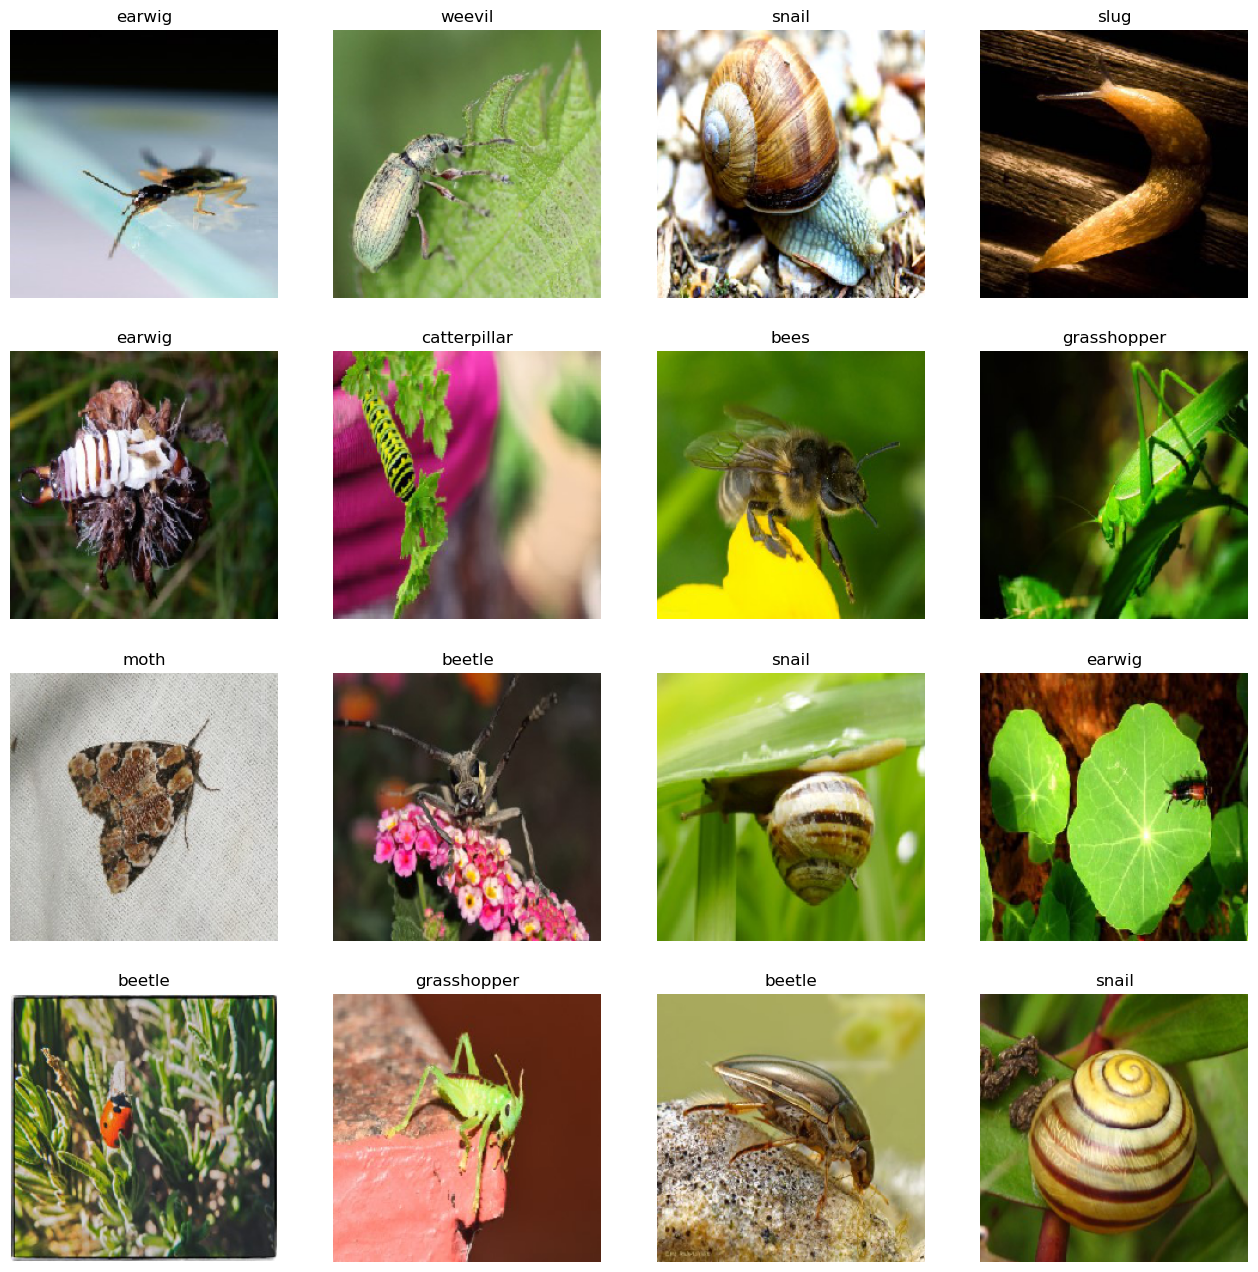

In [7]:
plt.figure(figsize=(16, 16))
for i in range(1, 17):
  plt.subplot(4, 4, i)
  img, label = train_generator.next()
  plt.imshow(img[i])
  plt.title(class_name[tf.argmax(label[i],axis=0).numpy()])
  plt.axis('off')
plt.show()

# Transfer learning

## VGG16

In [29]:
from tensorflow.keras.applications.vgg16 import VGG16
vgg = VGG16(weights="imagenet", include_top=False, input_shape= (224, 224, 3)) 
for layers in vgg.layers:
    layers.trainable = False
vgg.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [30]:

from tensorflow.keras.models import Model
from tensorflow.keras.layers import BatchNormalization
flatten_layer = Flatten()(vgg.output)
output = Dense(12, activation='softmax')(flatten_layer)
model = Model(inputs=vgg.input, outputs=output)

model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [31]:
from keras.optimizers import  Adam
model.compile(optimizer = Adam(learning_rate = 0.001), loss='categorical_crossentropy', metrics=['acc'])

In [32]:
history = model.fit(train_generator,
      epochs=5,
      validation_data=val_data)

Epoch 1/5
138/138 [==============================] - 245s 2s/step - loss: 1.4620 - acc: 0.5386 - val_loss: 1.1190 - val_acc: 0.6164
Epoch 2/5
138/138 [==============================] - 249s 2s/step - loss: 0.5166 - acc: 0.8398 - val_loss: 1.2858 - val_acc: 0.6119
Epoch 3/5
138/138 [==============================] - 289s 2s/step - loss: 0.2512 - acc: 0.9381 - val_loss: 1.0299 - val_acc: 0.6667
Epoch 4/5
138/138 [==============================] - 287s 2s/step - loss: 0.1356 - acc: 0.9823 - val_loss: 1.0797 - val_acc: 0.6758
Epoch 5/5
138/138 [==============================] - 302s 2s/step - loss: 0.0799 - acc: 0.9952 - val_loss: 1.0777 - val_acc: 0.6667


In [34]:
model.save("VGG16_pest.h5")
print("Saved model to disk")

C:\Users\swarnadeep acharya\anaconda3\Lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Saved model to disk


In [35]:
model = models.load_model('VGG16_pest.h5')
print("Model is loaded")

Model is loaded


In [36]:
train_acc = history.history['acc']
val_acc = history.history['val_acc']
train_loss = history.history['loss']
val_loss = history.history['val_loss']

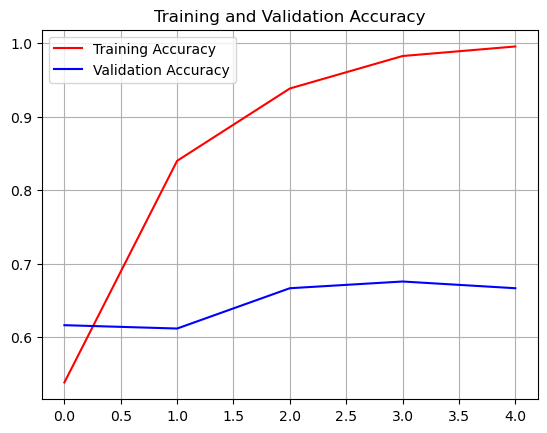

<Figure size 640x480 with 0 Axes>

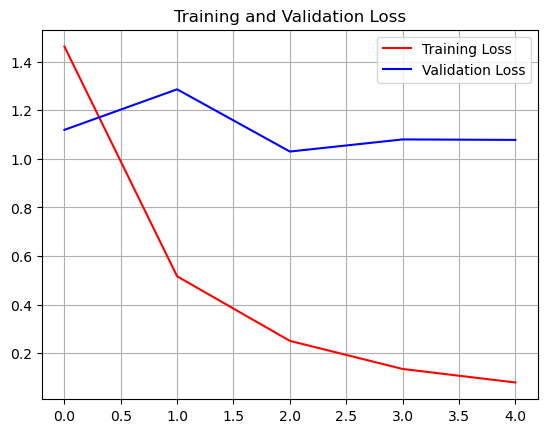

In [37]:
epochs = range(len(train_acc)) 
plt.plot(epochs, train_acc, 'r', label='Training Accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.grid()
plt.legend()
plt.figure()
plt.show()

plt.plot(epochs, train_loss, 'r', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.grid()
plt.legend()
plt.show()

In [38]:

fnames = test_generator.filenames

ground_truth = test_generator.classes
 
label2index = test_generator.class_indices
 
idx2label = dict((v,k) for k,v in label2index.items())

predictions = model.predict_generator(test_generator, steps=test_generator.samples/test_generator.batch_size,verbose=1)
predicted_classes = np.argmax(predictions,axis=1)

 

C:\Users\swarnadeep acharya\AppData\Local\Temp\ipykernel_5460\3117640201.py:9: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  predictions = model.predict_generator(test_generator, steps=test_generator.samples/test_generator.batch_size,verbose=1)


34/34 [==============================] - 111s 3s/step


In [39]:
errors = np.where(predicted_classes != ground_truth)[0]
print("No of errors = {}/{}".format(len(errors),test_generator.samples))
accuracy = ((test_generator.samples-len(errors))/test_generator.samples) * 100
accuracy

No of errors = 330/1099


69.97270245677889

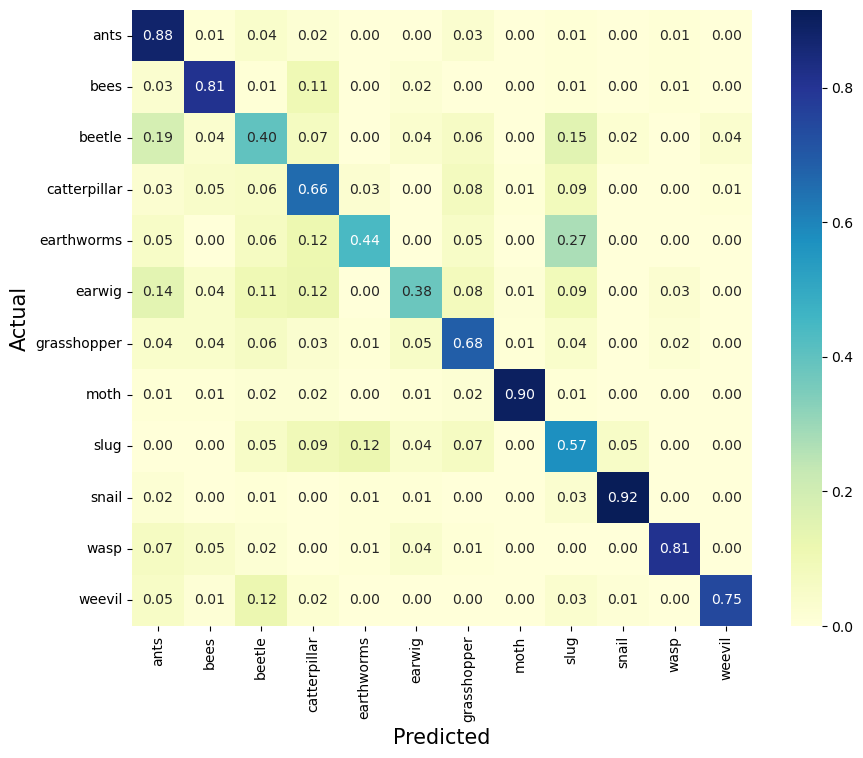

In [40]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import numpy as np
from matplotlib import pyplot as plt
cm = confusion_matrix(y_true=ground_truth, y_pred=predicted_classes)
cm = np.array(cm)
cmn = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
fig, ax = plt.subplots(figsize=(10,8))
sns.heatmap(cmn, annot=True, fmt='.2f', xticklabels=label2index, yticklabels=label2index, cmap="YlGnBu")
plt.ylabel('Actual', fontsize=15)
plt.xlabel('Predicted', fontsize=15)
plt.show(block=False)

In [41]:
from sklearn.metrics import classification_report
print(classification_report(ground_truth, predicted_classes, target_names=label2index))

              precision    recall  f1-score   support

        ants       0.61      0.88      0.72        99
        bees       0.77      0.81      0.79        95
      beetle       0.40      0.40      0.40        85
catterpillar       0.58      0.66      0.62       105
  earthworms       0.69      0.44      0.54        77
      earwig       0.60      0.38      0.47        76
 grasshopper       0.66      0.68      0.67        95
        moth       0.97      0.90      0.93       100
        slug       0.41      0.57      0.48        75
       snail       0.93      0.92      0.92        95
        wasp       0.93      0.81      0.87       106
      weevil       0.94      0.75      0.83        91

    accuracy                           0.70      1099
   macro avg       0.71      0.68      0.69      1099
weighted avg       0.72      0.70      0.70      1099



## MobileNetV2

In [55]:
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.models import Sequential
mobile_model = Sequential()
pretrained =  MobileNetV2(weights="imagenet", include_top=False, input_shape= (224, 224, 3)) 
for layers in pretrained.layers:
    layers.trainable = False
pretrained.summary()


Model: "mobilenetv2_1.00_224"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_3 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 Conv1 (Conv2D)              (None, 112, 112, 32)         864       ['input_3[0][0]']             
                                                                                                  
 bn_Conv1 (BatchNormalizati  (None, 112, 112, 32)         128       ['Conv1[0][0]']               
 on)                                                                                              
                                                                                                  
 Conv1_relu (ReLU)           (None, 112, 112, 32)         0         ['bn_Conv1[

In [56]:
mobile_model.add(pretrained)
mobile_model.add(Flatten())
mobile_model.add(Dense(32, activation='relu'))
mobile_model.add(BatchNormalization())
mobile_model.add(Dense(12,activation='softmax'))

In [57]:
mobile_model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenetv2_1.00_224 (Func  (None, 7, 7, 1280)        2257984   
 tional)                                                         
                                                                 
 flatten_2 (Flatten)         (None, 62720)             0         
                                                                 
 dense_2 (Dense)             (None, 32)                2007072   
                                                                 
 batch_normalization_297 (B  (None, 32)                128       
 atchNormalization)                                              
                                                                 
 dense_3 (Dense)             (None, 12)                396       
                                                                 
Total params: 4265580 (16.27 MB)
Trainable params: 200

In [58]:
mobile_model.compile(optimizer = Adam(learning_rate = 0.001), loss='categorical_crossentropy', metrics=['acc'])

In [59]:
history = mobile_model.fit(train_generator,
      steps_per_epoch=train_generator.samples/train_generator.batch_size,
      epochs=5,
      validation_data=val_data,
                           verbose =1)

Epoch 1/5
137/137 [==============================] - 52s 354ms/step - loss: 0.7201 - acc: 0.8052 - val_loss: 0.7324 - val_acc: 0.7945
Epoch 2/5
137/137 [==============================] - 47s 344ms/step - loss: 0.1729 - acc: 0.9716 - val_loss: 0.6575 - val_acc: 0.8174
Epoch 3/5
137/137 [==============================] - 47s 345ms/step - loss: 0.0422 - acc: 0.9982 - val_loss: 0.6799 - val_acc: 0.8037
Epoch 4/5
137/137 [==============================] - 47s 344ms/step - loss: 0.0171 - acc: 1.0000 - val_loss: 0.6583 - val_acc: 0.8082
Epoch 5/5
137/137 [==============================] - 47s 338ms/step - loss: 0.0093 - acc: 1.0000 - val_loss: 0.6706 - val_acc: 0.8037


In [60]:
mobile_model.save("mobilenet_pest.h5")
print("Saved model to disk")

C:\Users\swarnadeep acharya\anaconda3\Lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Saved model to disk


In [61]:
mobile_model = models.load_model('mobilenet_pest.h5')
print("Model is loaded")

Model is loaded


In [62]:
train_acc = history.history['acc']
val_acc = history.history['val_acc']
train_loss = history.history['loss']
val_loss = history.history['val_loss']

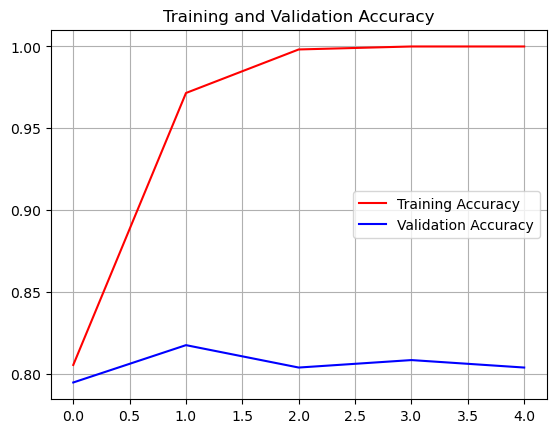

<Figure size 640x480 with 0 Axes>

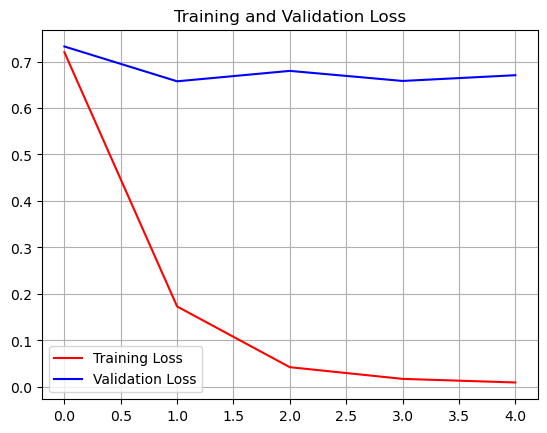

In [63]:
epochs = range(len(train_acc)) 
plt.plot(epochs, train_acc, 'r', label='Training Accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.grid()
plt.legend()
plt.figure()
plt.show()

plt.plot(epochs, train_loss, 'r', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.grid()
plt.legend()
plt.show()

In [64]:
fnames = test_generator.filenames

ground_truth = test_generator.classes
 
label2index = test_generator.class_indices
 
idx2label = dict((v,k) for k,v in label2index.items())

predictions = mobile_model.predict_generator(test_generator, steps=test_generator.samples/test_generator.batch_size,verbose=1)
predicted_classes = np.argmax(predictions,axis=1)

C:\Users\swarnadeep acharya\AppData\Local\Temp\ipykernel_15440\69000935.py:9: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  predictions = mobile_model.predict_generator(test_generator, steps=test_generator.samples/test_generator.batch_size,verbose=1)


34/34 [==============================] - 12s 305ms/step


In [65]:
errors = np.where(predicted_classes != ground_truth)[0]
print("No of errors = {}/{}".format(len(errors),test_generator.samples))
accuracy = ((test_generator.samples-len(errors))/test_generator.samples) * 100
accuracy

No of errors = 183/1099


83.34849863512284

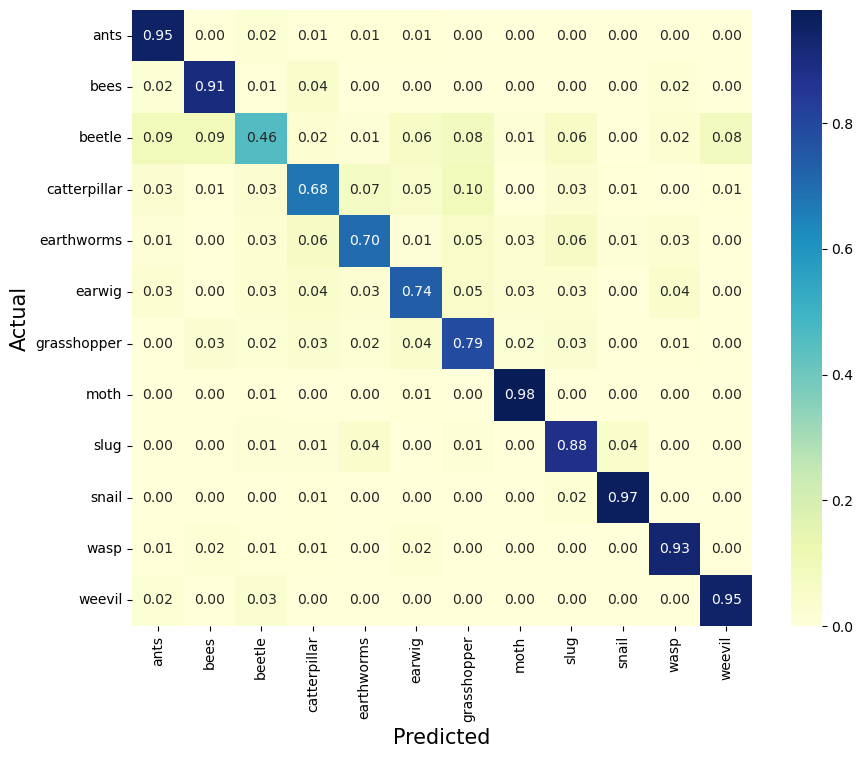

In [66]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import numpy as np
from matplotlib import pyplot as plt
cm = confusion_matrix(y_true=ground_truth, y_pred=predicted_classes)
cm = np.array(cm)
cmn = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
fig, ax = plt.subplots(figsize=(10,8))
sns.heatmap(cmn, annot=True, fmt='.2f', xticklabels=label2index, yticklabels=label2index, cmap="YlGnBu")
plt.ylabel('Actual', fontsize=15)
plt.xlabel('Predicted', fontsize=15)
plt.show(block=False)

In [67]:
from sklearn.metrics import classification_report
print(classification_report(ground_truth, predicted_classes, target_names=label2index))

              precision    recall  f1-score   support

        ants       0.83      0.95      0.89        99
        bees       0.86      0.91      0.88        95
      beetle       0.68      0.46      0.55        85
catterpillar       0.77      0.68      0.72       105
  earthworms       0.77      0.70      0.73        77
      earwig       0.75      0.74      0.74        76
 grasshopper       0.74      0.79      0.77        95
        moth       0.93      0.98      0.96       100
        slug       0.77      0.88      0.82        75
       snail       0.95      0.97      0.96        95
        wasp       0.91      0.93      0.92       106
      weevil       0.91      0.95      0.93        91

    accuracy                           0.83      1099
   macro avg       0.82      0.83      0.82      1099
weighted avg       0.83      0.83      0.83      1099



## InceptionNet

In [42]:
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.models import Sequential
inc_model = Sequential()
incep=  InceptionV3(weights="imagenet", include_top=False, input_shape= (224, 224, 3)) 
for layers in incep.layers:
    layers.trainable = False
incep.summary()


Model: "inception_v3"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 conv2d_203 (Conv2D)         (None, 111, 111, 32)         864       ['input_2[0][0]']             
                                                                                                  
 batch_normalization_203 (B  (None, 111, 111, 32)         96        ['conv2d_203[0][0]']          
 atchNormalization)                                                                               
                                                                                                  
 activation_203 (Activation  (None, 111, 111, 32)         0         ['batch_normalizati

In [43]:
inc_model.add(incep)
inc_model.add(Flatten())
inc_model.add(Dense(12,activation='softmax'))

In [44]:
inc_model.compile(optimizer = Adam(learning_rate = 0.001), loss='categorical_crossentropy', metrics=['acc'])

In [45]:
history = inc_model.fit(train_generator,
      steps_per_epoch=train_generator.samples/train_generator.batch_size,
      epochs=5,
      validation_data=val_data,
                           verbose =1)

Epoch 1/5
137/137 [==============================] - 71s 487ms/step - loss: 3.0563 - acc: 0.7718 - val_loss: 1.6963 - val_acc: 0.8539
Epoch 2/5
137/137 [==============================] - 72s 522ms/step - loss: 0.9401 - acc: 0.9074 - val_loss: 2.3342 - val_acc: 0.8219
Epoch 3/5
137/137 [==============================] - 72s 523ms/step - loss: 0.5589 - acc: 0.9418 - val_loss: 2.5422 - val_acc: 0.8311
Epoch 4/5
137/137 [==============================] - 71s 515ms/step - loss: 0.3374 - acc: 0.9604 - val_loss: 3.5293 - val_acc: 0.8082
Epoch 5/5
137/137 [==============================] - 68s 495ms/step - loss: 0.2049 - acc: 0.9741 - val_loss: 4.2009 - val_acc: 0.8082


In [47]:
inc_model.save("Incep_pest.h5")
print("Saved model to disk")

Saved model to disk


In [48]:
inc_model = models.load_model('Incep_pest.h5')
print("Model is loaded")

Model is loaded


In [49]:
train_acc = history.history['acc']
val_acc = history.history['val_acc']
train_loss = history.history['loss']
val_loss = history.history['val_loss']

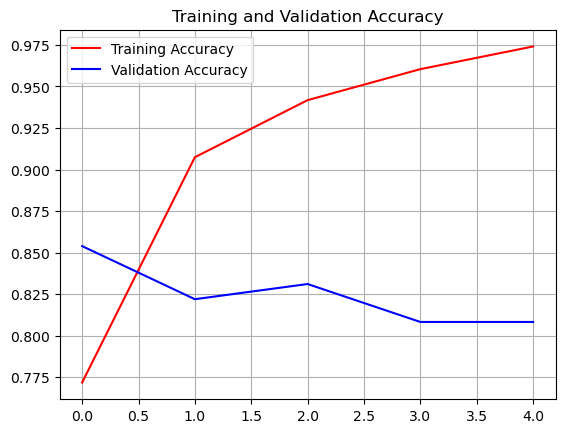

<Figure size 640x480 with 0 Axes>

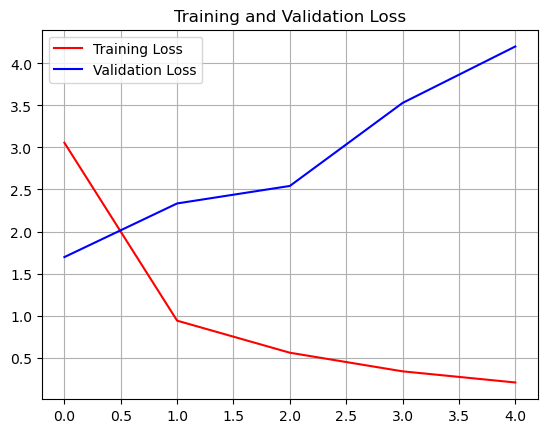

In [50]:
epochs = range(len(train_acc)) 
plt.plot(epochs, train_acc, 'r', label='Training Accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.grid()
plt.legend()
plt.figure()
plt.show()

plt.plot(epochs, train_loss, 'r', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.grid()
plt.legend()
plt.show()

In [51]:
fnames = test_generator.filenames

ground_truth = test_generator.classes
 
label2index = test_generator.class_indices
 
idx2label = dict((v,k) for k,v in label2index.items())

predictions = inc_model.predict_generator(test_generator, steps=test_generator.samples/test_generator.batch_size,verbose=1)
predicted_classes = np.argmax(predictions,axis=1)

C:\Users\swarnadeep acharya\AppData\Local\Temp\ipykernel_15440\2682493290.py:9: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  predictions = inc_model.predict_generator(test_generator, steps=test_generator.samples/test_generator.batch_size,verbose=1)


34/34 [==============================] - 18s 466ms/step


In [52]:
errors = np.where(predicted_classes != ground_truth)[0]
print("No of errors = {}/{}".format(len(errors),test_generator.samples))
accuracy = ((test_generator.samples-len(errors))/test_generator.samples) * 100
accuracy

No of errors = 173/1099


84.25841674249318

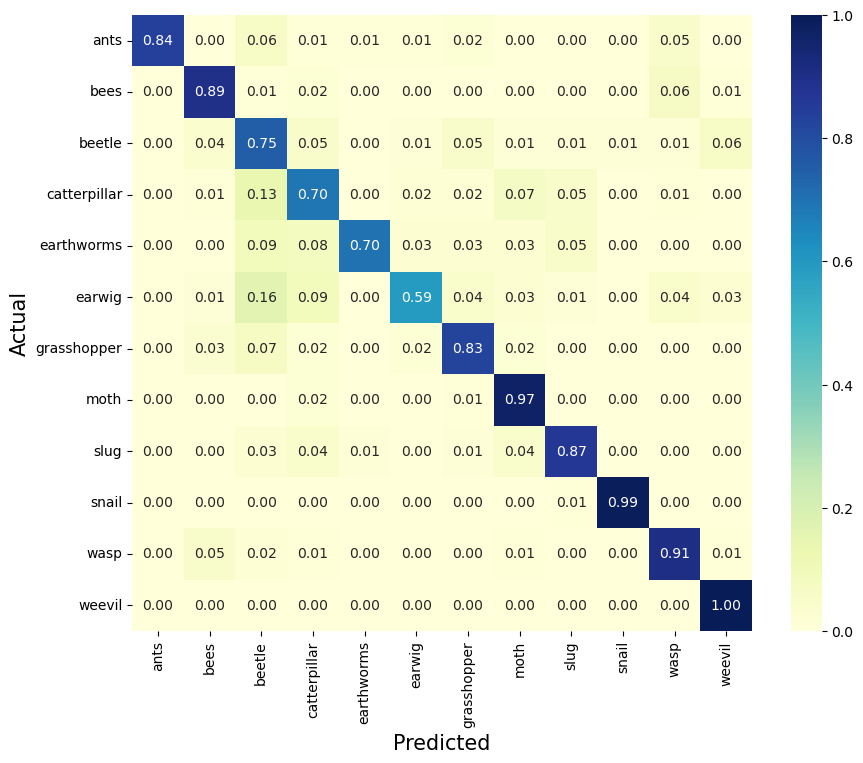

In [53]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import numpy as np
from matplotlib import pyplot as plt
cm = confusion_matrix(y_true=ground_truth, y_pred=predicted_classes)
cm = np.array(cm)
cmn = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
fig, ax = plt.subplots(figsize=(10,8))
sns.heatmap(cmn, annot=True, fmt='.2f', xticklabels=label2index, yticklabels=label2index, cmap="YlGnBu")
plt.ylabel('Actual', fontsize=15)
plt.xlabel('Predicted', fontsize=15)
plt.show(block=False)

In [54]:
from sklearn.metrics import classification_report
print(classification_report(ground_truth, predicted_classes, target_names=label2index))

              precision    recall  f1-score   support

        ants       1.00      0.84      0.91        99
        bees       0.87      0.89      0.88        95
      beetle       0.56      0.75      0.64        85
catterpillar       0.72      0.70      0.71       105
  earthworms       0.96      0.70      0.81        77
      earwig       0.85      0.59      0.70        76
 grasshopper       0.84      0.83      0.84        95
        moth       0.84      0.97      0.90       100
        slug       0.84      0.87      0.86        75
       snail       0.99      0.99      0.99        95
        wasp       0.86      0.91      0.88       106
      weevil       0.91      1.00      0.95        91

    accuracy                           0.84      1099
   macro avg       0.85      0.84      0.84      1099
weighted avg       0.85      0.84      0.84      1099



## ResNet50

In [78]:
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Sequential
res_model = Sequential()
resnet = ResNet50(weights="imagenet", include_top=False, input_shape= (224, 224, 3)) 
for layers in resnet.layers:
    layers.trainable = False
resnet.summary()

Model: "resnet50"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_7 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 conv1_pad (ZeroPadding2D)   (None, 230, 230, 3)          0         ['input_7[0][0]']             
                                                                                                  
 conv1_conv (Conv2D)         (None, 112, 112, 64)         9472      ['conv1_pad[0][0]']           
                                                                                                  
 conv1_bn (BatchNormalizati  (None, 112, 112, 64)         256       ['conv1_conv[0][0]']          
 on)                                                                                       

In [79]:
res_model.add(incep)
res_model.add(Flatten())
res_model.add(BatchNormalization())
res_model.add(Dense(12,activation='softmax'))

In [80]:
res_model.compile(optimizer = Adam(learning_rate = 0.001), loss='categorical_crossentropy', metrics=['acc'])

In [81]:
history = res_model.fit(train_generator,
      steps_per_epoch=train_generator.samples/train_generator.batch_size,
      epochs=5,
      validation_data=val_data,
                           verbose =1)

Epoch 1/5
137/137 [==============================] - 71s 476ms/step - loss: 2.3795 - acc: 0.8086 - val_loss: 2.5693 - val_acc: 0.8082
Epoch 2/5
137/137 [==============================] - 64s 469ms/step - loss: 0.8454 - acc: 0.9308 - val_loss: 3.8900 - val_acc: 0.7991
Epoch 3/5
137/137 [==============================] - 63s 458ms/step - loss: 0.3465 - acc: 0.9645 - val_loss: 3.1030 - val_acc: 0.8219
Epoch 4/5
137/137 [==============================] - 65s 476ms/step - loss: 0.2365 - acc: 0.9757 - val_loss: 3.4153 - val_acc: 0.8219
Epoch 5/5
137/137 [==============================] - 65s 474ms/step - loss: 0.2365 - acc: 0.9754 - val_loss: 4.1479 - val_acc: 0.8311


In [88]:
res_model.save("Resnet_pest.h5")
print("Saved model to disk")

Saved model to disk


In [89]:
res_model = models.load_model('Resnet_pest.h5')
print("Model is loaded")

Model is loaded


In [90]:
train_acc = history.history['acc']
val_acc = history.history['val_acc']
train_loss = history.history['loss']
val_loss = history.history['val_loss']

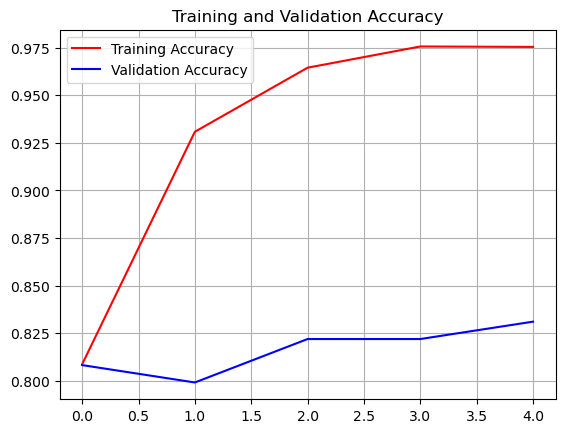

<Figure size 640x480 with 0 Axes>

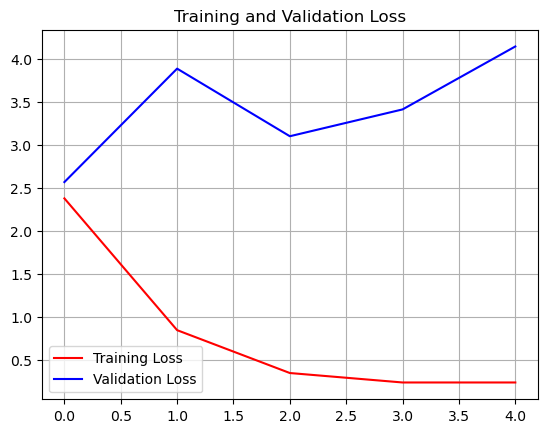

In [91]:
epochs = range(len(train_acc)) 
plt.plot(epochs, train_acc, 'r', label='Training Accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.grid()
plt.legend()
plt.figure()
plt.show()

plt.plot(epochs, train_loss, 'r', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.grid()
plt.legend()
plt.show()

In [92]:
fnames = test_generator.filenames

ground_truth = test_generator.classes
 
label2index = test_generator.class_indices
 
idx2label = dict((v,k) for k,v in label2index.items())

predictions = res_model.predict_generator(test_generator, steps=test_generator.samples/test_generator.batch_size,verbose=1)
predicted_classes = np.argmax(predictions,axis=1)

C:\Users\swarnadeep acharya\AppData\Local\Temp\ipykernel_15440\2005888262.py:9: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  predictions = res_model.predict_generator(test_generator, steps=test_generator.samples/test_generator.batch_size,verbose=1)


34/34 [==============================] - 18s 446ms/step


In [93]:
errors = np.where(predicted_classes != ground_truth)[0]
print("No of errors = {}/{}".format(len(errors),test_generator.samples))
accuracy = ((test_generator.samples-len(errors))/test_generator.samples) * 100
accuracy

No of errors = 163/1099


85.16833484986351

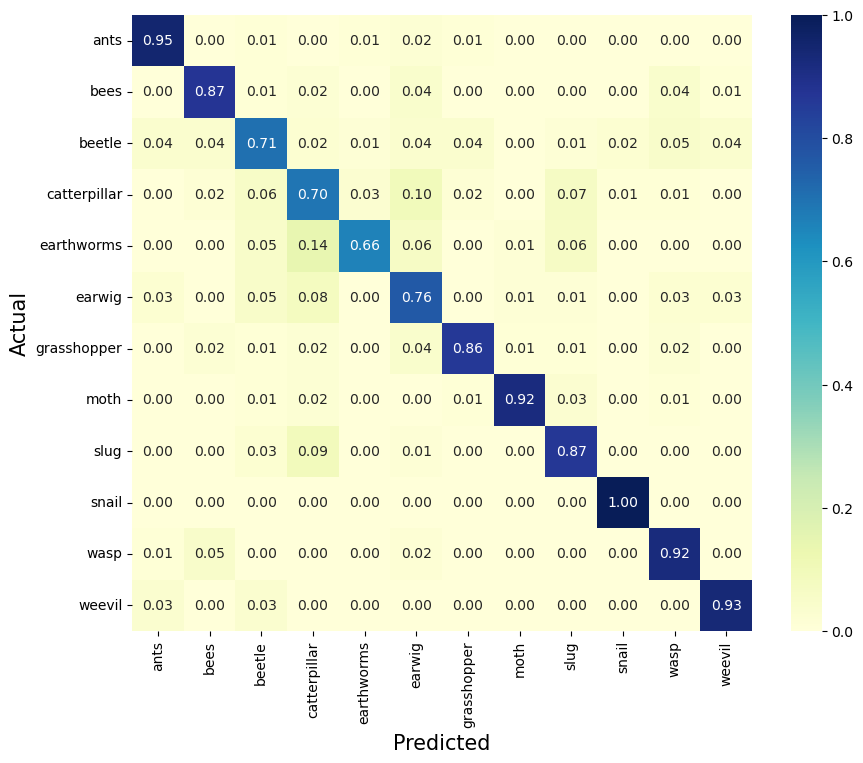

In [94]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import numpy as np
from matplotlib import pyplot as plt
cm = confusion_matrix(y_true=ground_truth, y_pred=predicted_classes)
cm = np.array(cm)
cmn = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
fig, ax = plt.subplots(figsize=(10,8))
sns.heatmap(cmn, annot=True, fmt='.2f', xticklabels=label2index, yticklabels=label2index, cmap="YlGnBu")
plt.ylabel('Actual', fontsize=15)
plt.xlabel('Predicted', fontsize=15)
plt.show(block=False)

In [95]:
from sklearn.metrics import classification_report
print(classification_report(ground_truth, predicted_classes, target_names=label2index))

              precision    recall  f1-score   support

        ants       0.91      0.95      0.93        99
        bees       0.87      0.87      0.87        95
      beetle       0.72      0.71      0.71        85
catterpillar       0.70      0.70      0.70       105
  earthworms       0.91      0.66      0.77        77
      earwig       0.65      0.76      0.70        76
 grasshopper       0.92      0.86      0.89        95
        moth       0.97      0.92      0.94       100
        slug       0.78      0.87      0.82        75
       snail       0.97      1.00      0.98        95
        wasp       0.88      0.92      0.90       106
      weevil       0.93      0.93      0.93        91

    accuracy                           0.85      1099
   macro avg       0.85      0.85      0.85      1099
weighted avg       0.86      0.85      0.85      1099

